In [9]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict


from Joint_HDRDN import Joint_HDRDN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
npypath = '/data/asim/ISP/HDR_transformer/data/RAW/raw-2022-0606-2151-4147.npz'
imdata = np.load(npypath)

sht = imdata['sht']
mid = imdata['mid']
lng = imdata['lng']
hdr = imdata['hdr']

crop_size = 992
H, W = hdr.shape[1], hdr.shape[2]
start_h = (H - crop_size) // 2
start_w = (W - crop_size) // 2

sht_crop = sht[:, start_h:start_h+crop_size, start_w:start_w+crop_size]
mid_crop = mid[:, start_h:start_h+crop_size, start_w:start_w+crop_size]
lng_crop = lng[:, start_h:start_h+crop_size, start_w:start_w+crop_size]
hdr_crop = hdr[:, start_h:start_h+crop_size, start_w:start_w+crop_size]

print(sht_crop.shape, hdr_crop.shape)

(8, 992, 992) (4, 992, 992)


In [17]:

def bayer_to_rgb(bayer_array):
    H, W = bayer_array.shape[1:]
    bayer = np.zeros((H * 2, W * 2), dtype=bayer_array.dtype)
    bayer[0::2, 0::2] = bayer_array[0]
    bayer[0::2, 1::2] = bayer_array[1]
    bayer[1::2, 0::2] = bayer_array[2]
    bayer[1::2, 1::2] = bayer_array[3]

    bayer = np.clip(bayer, 0, 1)
    bayer = (bayer * 65535).astype(np.uint16)

    #print("Max value before demosaicing:", np.max(bayer))

    rgb = cv2.cvtColor(bayer, cv2.COLOR_BayerBG2RGB)

    rgb = rgb.astype(np.float32) / 65535.0

    #print("Max RGB value after demosaicing:", np.max(rgb))

    # --- Normalize to maximum brightness ---
    if np.max(rgb) > 0:
        rgb = rgb / np.max(rgb)

    # Optional: Apply gamma correction (makes image bright and natural)
    rgb = np.clip(rgb, 0, 1) ** (1/2.2)

    return rgb



In [18]:
def to_tensor(np_array):
    t = torch.from_numpy(np_array).float()
    return t

im1 = to_tensor(sht_crop).to(device).unsqueeze(0)
im2 = to_tensor(mid_crop).to(device).unsqueeze(0)
im3 = to_tensor(lng_crop).to(device).unsqueeze(0)
ref_hdr = to_tensor(hdr_crop).to(device).unsqueeze(0)
im1[:, :4, :, :].shape, ref_hdr.shape

(torch.Size([1, 4, 992, 992]), torch.Size([1, 4, 992, 992]))

In [19]:

model = Joint_HDRDN(n_channel =8, out_channel = 4, embed_dim = 60, depths=[4, 4, 4])
model = nn.DataParallel(model)
# 2. Load state_dict from file
state_dict = torch.load('Joint_HDRDN.pth', map_location='cuda')  # load directly to GPU

model.load_state_dict(state_dict)


<All keys matched successfully>

In [20]:
model.eval()
with torch.no_grad():
    generate_hdr = model(im1, im2, im3)
generate_hdr.shape

torch.Size([1, 4, 992, 992])

In [21]:
im1_rgb = bayer_to_rgb(im1[:, :4, :, :].squeeze().cpu().numpy())
im2_rgb = bayer_to_rgb(im2[:, :4, :, :].squeeze().cpu().numpy())
im3_rgb = bayer_to_rgb(im3[:, :4, :, :].squeeze().cpu().numpy())
ref_hdr_rgb = bayer_to_rgb(ref_hdr.squeeze().cpu().numpy())
generate_hdr_rgb = bayer_to_rgb(generate_hdr.squeeze().cpu().numpy())
generate_hdr_rgb.shape

(1984, 1984, 3)

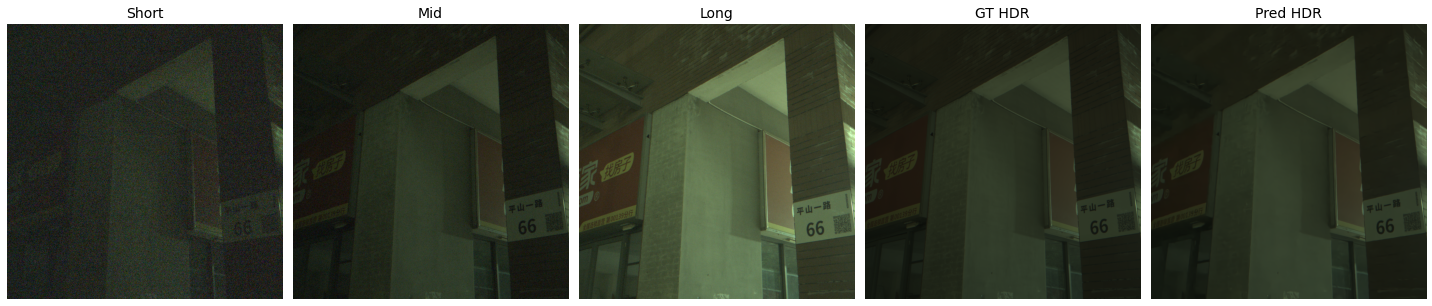

In [22]:
imgs = [im1_rgb, im2_rgb, im3_rgb, ref_hdr_rgb, generate_hdr_rgb]
titles = ['Short', 'Mid', 'Long', 'GT HDR', 'Pred HDR']

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
    ax[i].set_title(titles[i], fontsize=14)
plt.tight_layout()
plt.show()